# Neural coherent Ising machine for combinatorial optimization over network dynamical processes

As a illustration, we consider the discrete-time SIR model and its influence maximization problem. The
iteration reads
$$s_i^{t+1} = s_i^{t} \prod_{i=1}^N(1-\beta A_{ij}x_j^t)$$
$$r_i^{t+1} = r_i^{t} + \gamma x_i^t $$
$$x_i^{t+1} = (1- \gamma) x_i^t + s_i^{t}  \left(1-\prod_{i=1}^N(1-\beta A_{ij}x_j^t)\right)$$
The objective is to 
$$\max_{x^0\in \{0,1\}^N}\sum_{i=1}^N r_i^{\infty} \quad \text{s.t.} \sum_{i=1}^N x_i^0 = C.$$
We use neural simulated bifurcation for this optimization. Let $f:x^0\mapsto r^{\infty}$ be the mapping that takes the initial condition to output. Note that here $f(x)$ can either be a dynamical model or a neural suorrogate. 

In particular, we consider the double-well potential in simulated bifurcation or coherent Ising machine. (The difference of the two things the first is optimized by Hamiltonian dynamics while the later by gradient dynamics).
$$h(x)=\frac{1}{4}2-\frac{a}{2}x^2$$
The function has one global minimum $x=0$ when $a<0$, and three stationary points when $a>0$
$$x=0, \quad, x = \pm\sqrt{a} .$$
A visualization is as following:


In [13]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


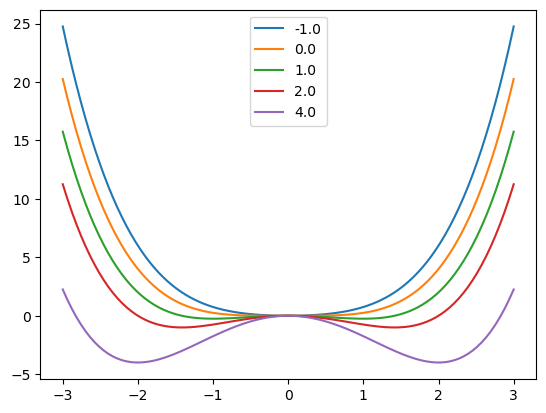

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def double_well(x,a):
    return x**4/4 - a*x**2/2

x = np.linspace(-3,3,100)
a_list = np.asarray([-1,0.0,1,2,4])
for _, a in enumerate(a_list):
    y = double_well(x,a)
    plt.plot(x,y,label=str(a))
plt.legend()
plt.show()

We define a trainable parameter $w$ and denote the sigmoid function as $\sigma(\cdot)$
The neural objective reads:
$$\min_{w\in \mathbb{R}^N} -\sum_{i=1}^N f_i\left(\sigma(w)\right) + \frac{1}{4}w_i^4 -\frac{a}{2}w_i^2 \quad \text{s.t.} \sum_{i=1}^N \sigma(w_i) = C.$$
In other words, we confine each spin with a potential term. When we increase $a$, the potential turns from single-well to double-well, therefore it is a kind of annealing the landscape.

Note that another essential point of CIM is we should start with $w\approx 0$. In this case when we increase $a$ slowly, $w$ will undergoes a pitchfork bifurcation.  

A remark that will be used in the following (adapted to the message-passing scheme in PyG) 
$$q_i \equiv \prod_{i=1}^N(1-\beta A_{ij}x_j^t) = \exp \left(\sum_{i=1}^N \log (1-\beta A_{ij}x_j^t)\right)= \exp \left(\sum_{i=1}^N  A_{ij} \log (1-\beta x_j^t)\right)$$


In [15]:
import networkx as nx 
from torch_geometric.nn import MessagePassing
import torch
from torch_geometric.utils import dense_to_sparse
import torch.nn.functional as F

class SIR(MessagePassing):
    def __init__(self, N, beta, gamma, C ,steps):
        super().__init__(aggr="add")
        self.N = N
        self.beta = beta
        self.gamma = gamma
        self.C = C
        self.steps = steps
        self.train_w = True
        self.w = torch.nn.Parameter(torch.zeros(N,1))

    def init_state(self,test=False,x0=None):
        if x0 is None:
            if test: #rounding to get binary initial condition
                x = torch.zeros(self.N,1).to(self.w.device)
                ind = torch.argsort(self.w.view(-1),descending=True)
                x[ind[:self.C]] = 1
            else:
                x = torch.sigmoid(self.w) # x_i in [0,1]
                #print(x.sum())
                #if x.sum()>self.C:
                x = x * self.C / x.sum()  # number of seeds constraint
        else: # manual input
            x = x0            
        r = torch.zeros(self.N,1).to(x.device)
        s = 1 - x
        return s, x ,r
    
    def single_step_forward(self, edge_index, s, x, r):
        q = self.propagate(edge_index, x=torch.log(1-self.beta*x))
        q = torch.exp(q)
        s, x, r = s*q, (1-self.gamma)*x + s*(1-q) , r+ self.gamma*x
        return s, x, r

    def forward(self, edge_index, test=False, x0=None):
        s, x, r = self.init_state(test, x0)
        for i in range(self.steps):
           s, x ,r = self.single_step_forward(edge_index,s,x,r)
        return s, x, r

    def message(self, x_j):
        return x_j

In [4]:
import torch
a = torch.tensor([-5])
print(torch.sigmoid(a))

tensor([0.0067])


In [10]:
# spreading model parameters
beta = 0.15
gamma = 1.0
steps = 30
C = 7

# graph 
# generate a graph
# N = 200
# k = 6
# G = nx.barabasi_albert_graph(N,k)
# A = torch.from_numpy(nx.to_numpy_array(G))
# edge_index,_ = dense_to_sparse(A)
# degree = A.sum(dim=1)

from torch_geometric.datasets import Planetoid
from torch_geometric.utils import degree

dataset = Planetoid(root='/home/zjy/project/MetaIM/data/cora', name='cora')
data = dataset[0]
edge_index = data.edge_index
d = degree(edge_index[1])
N = data.num_nodes
# degree-greedy baseline. 
ind = torch.argsort(d,descending=True)
x0 = torch.zeros(N,1)
x0[ind[:C]] = 1
model = SIR(N,beta,gamma,C,steps)
_,x,r = model(edge_index, x0=x0)
print('degree-greddy baseline:',float(r.mean()))

degree-greddy baseline: 0.09952475130558014


Processing...
Done!


In [11]:
alpha = 1.0 # weight of potential term
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
model = SIR(N,beta,gamma,C,steps).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def potential(w,a):
    h = w**4/4 - a*w**2/2
    return h.mean()

def train_epoch(edge_index, a):
    edge_index = edge_index.to(device)
    model.train()
    optimizer.zero_grad()
    _, _, r = model(edge_index)
    _, x0, _ = model.init_state()
    init_num = x0.sum()
    loss = -r.mean()+ alpha*potential(x0-C/N,a)
    #loss = -r.mean()
    loss.backward()
    optimizer.step()
    return float(r.mean()), float(init_num)

def test_epoch(edge_index):
    model.eval()
    edge_index = edge_index.to(device)
    _, _, r = model(edge_index,test=True)
    return float(r.mean())

a = -2
for epoch in range(1, 1001):
    # if epoch < 100: # the annealing scheme, need to be optimized
    #     a = 0
    # else:
    if epoch %1==0:
        a += 0.01
    #print(model.w)
    infected_tr, num = train_epoch(edge_index, a)
    infected_te = test_epoch(edge_index)
    print('init num:{:.2f}'.format(num),'infected train:{:.4f}'.format(infected_tr), 'infected test:{:.4f}'.format(infected_te))

cuda:0
init num:7.00 infected train:0.0977 infected test:0.0968
init num:7.00 infected train:0.0977 infected test:0.0968
init num:7.00 infected train:0.0977 infected test:0.0968
init num:7.00 infected train:0.0977 infected test:0.0968
init num:7.00 infected train:0.0977 infected test:0.0968
init num:7.00 infected train:0.0977 infected test:0.0968
init num:7.00 infected train:0.0977 infected test:0.0968
init num:7.00 infected train:0.0977 infected test:0.0968
init num:7.00 infected train:0.0977 infected test:0.0968
init num:7.00 infected train:0.0977 infected test:0.0968
init num:7.00 infected train:0.0977 infected test:0.0968
init num:7.00 infected train:0.0977 infected test:0.0968
init num:7.00 infected train:0.0977 infected test:0.0968
init num:7.00 infected train:0.0977 infected test:0.0968
init num:7.00 infected train:0.0977 infected test:0.0998
init num:7.00 infected train:0.0977 infected test:0.0998
init num:7.00 infected train:0.0977 infected test:0.0998
init num:7.00 infected t